In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def do_canny(frame):
    # Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # Applies a 5x5 gaussian blur with deviation of 0 to frame - not mandatory since Canny will do this for us
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Applies Canny edge detector with minVal of 50 and maxVal of 150
    canny = cv2.Canny(blur, 50, 150)
    #plt.imshow(canny)
    return canny

def do_segment(frame):
    # Since an image is a multi-directional array containing the relative intensities of each pixel in the image, we can use frame.shape to return a     #tuple: [number of rows, number of columns, number of channels] of the dimensions of the frame
    # frame.shape[0] give us the number of rows of pixels the frame has. Since height begins from 0 at the top, the y-coordinate of the bottom of       #the frame is its height
    height = frame.shape[0]
    #width = frame.shape[1]
    # Creates a triangular polygon for the mask defined by three (x, y) coordinates
    polygons = np.array([
                            [(0, height), (1200, height), (1000,200), (400,200)]
                        ])
    # Creates an image filled with zero intensities with the same dimensions as the frame
    mask = np.zeros_like(frame)
    # Allows the mask to be filled with values of 1 and the other areas to be filled with values of 0
    cv2.fillPoly(mask, polygons, 255)
    # A bitwise and operation between the mask and frame keeps only the triangular area of the frame
    segment = cv2.bitwise_and(frame, mask)
    #plt.imshow(segment)
    return segment
   

def calculate_lines(frame, lines):
    # Empty arrays to store the coordinates of the left and right lines
    left = []
    right = []
    # Loops through every detected line
    for line in lines:
        # Reshapes line from 2D array to 1D array
        
        x1, y1, x2, y2 = line.reshape(4)
        
        # Fits a linear polynomial to the x and y coordinates and returns a vector of coefficients which describe the slope and y-intercept
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        
        y_intercept = parameters[1]
        # If slope is negative, the line is to the left of the lane, and otherwise, the line is to the right of the lane
        if slope < 0:
            left.append((slope, y_intercept))
        else:
            right.append((slope, y_intercept))
    # Averages out all the values for left and right into a single slope and y-intercept value for each line
    
    left_avg = np.average(left, axis = 0)
    right_avg = np.average(right, axis = 0)
    # Calculates the x1, y1, x2, y2 coordinates for the left and right lines
    
    
    left_line = calculate_coordinates(frame, left_avg)
    right_line = calculate_coordinates(frame, right_avg)
    
    return np.array([left_line, right_line])

def calculate_coordinates(frame, parameters):
    slope, intercept = parameters
    # Sets initial y-coordinate as height from top down (bottom of the frame)
    y1 = frame.shape[0]
    # Sets final y-coordinate as 150 above the bottom of the frame
    y2 = int(y1 - 150)
    # Sets initial x-coordinate as (y1 - b) / m since y1 = mx1 + b
    x1 = int((y1 - intercept) / slope)
    # Sets final x-coordinate as (y2 - b) / m since y2 = mx2 + b
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

def visualize_lines(frame, lines):
    # Creates an image filled with zero intensities with the same dimensions as the frame
    lines_visualize = np.zeros_like(frame)
    # Checks if any lines are detected
    boundary =[]
    #print(lines)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            # Draws lines between two coordinates with green color and 5 thickness
            cv2.line(lines_visualize, (x1, y1), (x2, y2), (0, 255, 0), 5)
            #laneboundary = (x1,y1),(x2,y2)
            boundary.append([x1,y1])
            boundary.append([x2,y2])
            #print(x1,y1,x2,y2)
        #boundary = np.array(boundary )
        #print(boundary)
                
    #print(boundary)
    boundary =np.array(boundary)
    
    return [lines_visualize, boundary]


if __name__ == '__main__':
    
    sourceFolder = '/Users/sarjana/Documents/UMD /Spring 2020/ENSE 622/dataset/images'
    destFolder = '/Users/sarjana/Documents/UMD /Spring 2020/ENSE 622/dataset/Medium Code'
    filename = os.listdir(sourceFolder)
    for file in filename :
        if file.endswith('.png') :
            
            frame = cv2.imread('/Users/sarjana/Documents/UMD /Spring 2020/ENSE 622/dataset/images' +'/' +file)
            
            canny = do_canny(frame)
    
            segment = do_segment(canny)
            hough = cv2.HoughLinesP(segment, 2, np.pi / 180, 100, np.array([]), minLineLength = 100, maxLineGap = 50)
    
            # Averages multiple detected lines from hough into one line for left border of lane and one line for right border of lane
            lines = calculate_lines(frame, hough)
            #border =[(lines[0][0], lines[0][1]),(lines[0][2], lines[0][3]),(lines[1][0], lines[1][1]),(lines[1][2], lines[1][3])]
            #border = np.array(border)
    
            # Visualizes the lines
            [lines_visualize, boundary] = visualize_lines(frame, lines)
            #print(laneboundary)
            output = np.zeros_like(lines_visualize)
            cv2.fillConvexPoly(output,np.int32([boundary]),(255, 255,255))
    
            # Overlays lines on frame by taking their weighted sums and adding an arbitrary scalar value of 1 as the gamma argument
            #output = cv2.addWeighted(frame, 0.9, lines_visualize, 1, 1)
            # Opens a new window and displays the output frame
            cv2.imwrite(destFolder + '/' + file, output)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

/Users/sarjana/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RankWarning: Polyfit may be poorly conditioned


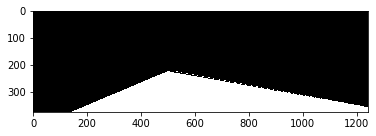